## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk import tokenize
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model, metrics


[nltk_data] Error loading punkt_tab: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


## Read data

Data can be found here : https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset/data

In [2]:
text_data = pd.read_csv("/kaggle/input/train-data/train_v2_drcat_02.csv")

In [3]:
text_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [4]:
text_data.nunique()

text             44868
label                2
prompt_name         15
source              17
RDizzl3_seven        2
dtype: int64

Let's keep the original prompts

In [5]:
seven_text_data = text_data[text_data['RDizzl3_seven'] == True]

In [6]:
seven_text_data.nunique()

text             20450
label                2
prompt_name          7
source              17
RDizzl3_seven        1
dtype: int64

Here we can see that we have 7 different prompts left.

In [7]:
seven_text_data['prompt_name'].unique()

array(['Car-free cities', '"A Cowboy Who Rode the Waves"',
       'Exploring Venus', 'Facial action coding system',
       'The Face on Mars', 'Driverless cars',
       'Does the electoral college work?'], dtype=object)

In [8]:
# Remove the " " " in the prompt names
seven_text_data['prompt_name'] = seven_text_data['prompt_name'].str.replace('''"''','')
seven_text_data['prompt_name'].unique()

<ipython-input-8-fc364d44c5c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['prompt_name'] = seven_text_data['prompt_name'].str.replace('''"''','')


array(['Car-free cities', 'A Cowboy Who Rode the Waves',
       'Exploring Venus', 'Facial action coding system',
       'The Face on Mars', 'Driverless cars',
       'Does the electoral college work?'], dtype=object)

In [9]:
seven_text_data['source'].unique()

array(['persuade_corpus', 'mistral7binstruct_v2', 'darragh_claude_v6',
       'llama_70b_v1', 'llama2_chat', 'darragh_claude_v7',
       'falcon_180b_v1', 'chat_gpt_moth', 'radek_500',
       'mistral7binstruct_v1', 'NousResearch/Llama-2-7b-chat-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'palm-text-bison1',
       'cohere-command', 'radekgpt4', 'train_essays', 'kingki19_palm'],
      dtype=object)

## Data mining and Feature engineering

### Visualization

Class imbalance

In [10]:
grouped_data=seven_text_data.groupby('label').count().reset_index()

<Axes: xlabel='label', ylabel='text'>

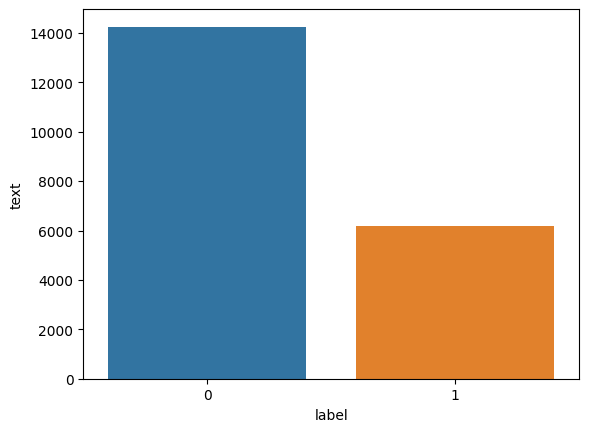

In [11]:
sns.barplot(grouped_data, x = 'label', y = 'text')

We notice a huge class imbalance : there are more handwritten text than AI generated

Add essay length column

In [12]:
seven_text_data['length'] = seven_text_data['text'].str.len()
seven_text_data.head()

<ipython-input-12-c6c905201ebb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['length'] = seven_text_data['text'].str.len()


,text,label,prompt_name,source,RDizzl3_seven,length
1168,Cars have been around for awhile and they have...,0,Car-free cities,persuade_corpus,True,3114
1169,Have you ever thought what it would be like no...,0,Car-free cities,persuade_corpus,True,1132
1170,What you are about to read is going to give yo...,0,Car-free cities,persuade_corpus,True,3319
1171,cars have many flaws nd and in this day and ag...,0,Car-free cities,persuade_corpus,True,1030
1172,There are many advantages of limiting car usag...,0,Car-free cities,persuade_corpus,True,1860


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='length', ylabel='Count'>

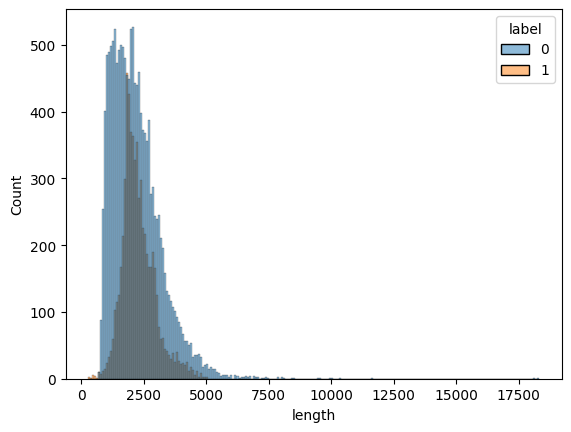

In [13]:
sns.histplot(seven_text_data, x = 'length', hue = 'label')

In [14]:
mapping = dict(zip(seven_text_data['prompt_name'].unique(), range(7)))
seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']


<ipython-input-14-5dea6896ae5f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']
<ipython-input-14-5dea6896ae5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']


<Axes: xlabel='prompt_id', ylabel='text'>

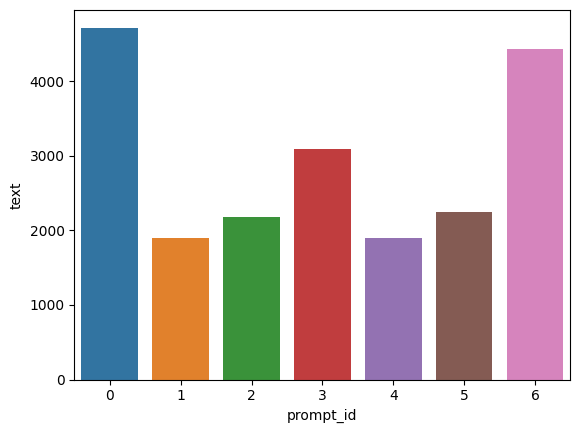

In [15]:
sns.barplot(seven_text_data.groupby('prompt_id').count().reset_index(),x = 'prompt_id', y = 'text')

<ipython-input-16-f01482ba925c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']
<ipython-input-16-f01482ba925c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']


Text(0.5, 1.0, 'Number of essays by source')

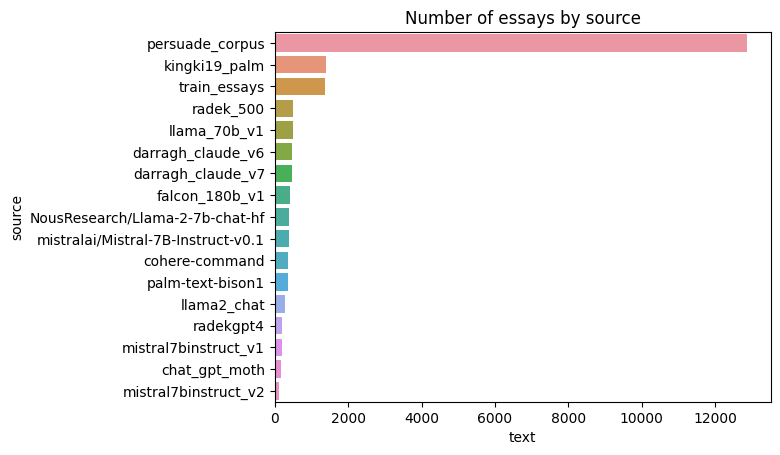

In [16]:
mapping_source = dict(zip(seven_text_data['source'].unique(), range(len(seven_text_data['source'].unique()))))
seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']
sorted_seven_text_data = seven_text_data.groupby('source').count().sort_values("text", ascending=False).reset_index()
sns.barplot(sorted_seven_text_data,x = 'text', y = 'source', orient = 'h')
plt.title("Number of essays by source")

The sources are highly skewed so me might need to balance this later

In [17]:
def word_count(text):
    text_list = text.split()
    return len(text_list)


In [18]:
seven_text_data['word_count'] = seven_text_data['text'].apply(word_count)
seven_text_data.head()

<ipython-input-18-f3baf03f0dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['word_count'] = seven_text_data['text'].apply(word_count)


,text,label,prompt_name,source,RDizzl3_seven,length,prompt_id,source_id,word_count
1168,Cars have been around for awhile and they have...,0,Car-free cities,persuade_corpus,True,3114,0,0,537
1169,Have you ever thought what it would be like no...,0,Car-free cities,persuade_corpus,True,1132,0,0,212
1170,What you are about to read is going to give yo...,0,Car-free cities,persuade_corpus,True,3319,0,0,620
1171,cars have many flaws nd and in this day and ag...,0,Car-free cities,persuade_corpus,True,1030,0,0,190
1172,There are many advantages of limiting car usag...,0,Car-free cities,persuade_corpus,True,1860,0,0,314


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='word_count', ylabel='Count'>

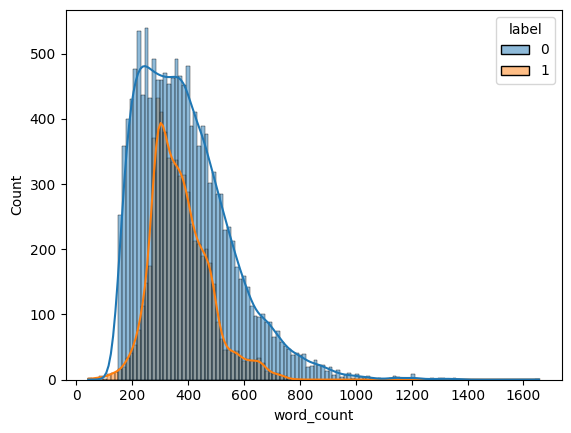

In [19]:
sns.histplot(seven_text_data, x = 'word_count',kde=True, hue='label')

In [20]:
seven_text_data['mean_word_length'] = seven_text_data['text'].apply(
    lambda x: np.mean([len(word) for word in x.split()])
)

<ipython-input-20-040c5bccf9c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['mean_word_length'] = seven_text_data['text'].apply(


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='mean_word_length', ylabel='Count'>

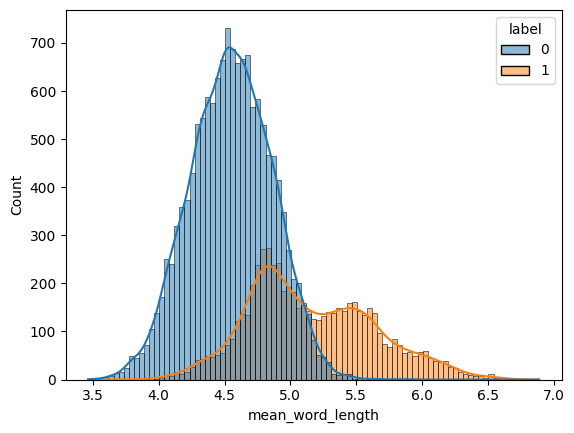

In [21]:
sns.histplot(seven_text_data, x = 'mean_word_length',kde=True, hue='label')

In [22]:
seven_text_data['mean_sent_length'] = seven_text_data['text'].apply(
    lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)])
)


<ipython-input-22-82c91d421ccd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['mean_sent_length'] = seven_text_data['text'].apply(


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='mean_sent_length', ylabel='Count'>

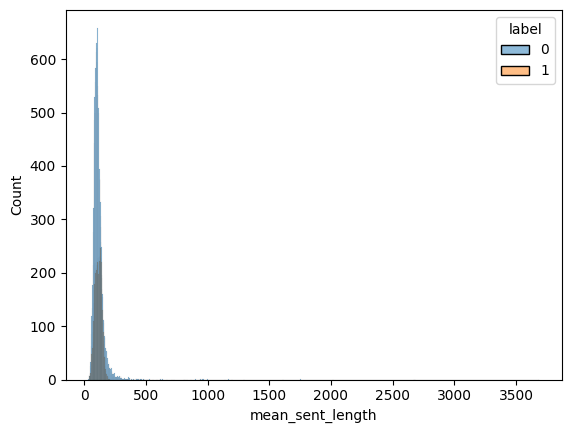

In [23]:
sns.histplot(seven_text_data, x = 'mean_sent_length', hue='label')

### TF-IDF

Example of an essay

In [24]:
random_idx = np.random.randint(seven_text_data.shape[0])
seven_text_data.iloc[random_idx]['text']

'Mr. Senator,\n\nI think that the Electoral College is a decent way to vote for president. But is it really the best way? Though the Electoral College elects presidents in a way favored by many, it doesn\'t allow for people to directly vote for the president. Because of that, the Electoral College should be abolished and changed to election by popular vote.\n\nVoting by Electoral College can make things unfair. As stated in the article, "The Indefensible Electoral College", "Under the electoral college system, voters vote not for the president, but for a state of electors, who in turn elect the president" (Source 2). That statement basically says that when a voter goes to vote, they aren\'t voting for the president, but for someone to go and vote for them. Also, who exactly are the people we go and let vote for the person leading our country? According to the article, "Electors can be anyone not holding public office" (Source 2). The people who go and vote can\'t control who these elec

After going through the corpus we see \n to jump lines and  \ before ' that we have to manage for text processing.

In [25]:
corpus = seven_text_data['text']
vectorizer = TfidfVectorizer(max_features = 10000,
                            stop_words = 'english',
                            )
X = vectorizer.fit_transform(corpus,
                            )

In [26]:
features = vectorizer.get_feature_names_out()

In [27]:
print("vectorized corpus dimensions : ", X.shape)
print("corpus dataset dimensions : ", seven_text_data.shape)

vectorized corpus dimensions :  (20450, 10000)
corpus dataset dimensions :  (20450, 11)


Each line of X represents an essay in the corpus, and each column represents a word

## Machine learning task

In [28]:
y = seven_text_data['label'].values
y.shape

(20450,)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(corpus,y)

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
MAX_NB_WORDS = 5000  # Nombre max de mots dans le vocabulaire
MAX_SEQUENCE_LENGTH = 10  # Longueur max d'une séquence

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

EMBEDDING_DIM = 100  # Dimension de l'embedding

model = Sequential([
    Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=True),  # LSTM avec retour des séquences
    Dropout(0.2),
    LSTM(64),  # Deuxième couche LSTM
    Dense(1, activation="sigmoid")  # Sigmoid car classification binaire
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
EPOCHS = 50
BATCH_SIZE = 32

model.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_pad, y_test))

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8145 - auc: 0.8395 - loss: 0.4096 - val_accuracy: 0.9012 - val_auc: 0.9475 - val_loss: 0.2591
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9254 - auc: 0.9662 - loss: 0.2015 - val_accuracy: 0.9042 - val_auc: 0.9495 - val_loss: 0.2470
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9483 - auc: 0.9831 - loss: 0.1399 - val_accuracy: 0.9042 - val_auc: 0.9482 - val_loss: 0.2602
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9613 - auc: 0.9892 - loss: 0.1080 - val_accuracy: 0.8938 - val_auc: 0.9416 - val_loss: 0.3127
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9660 - auc: 0.9923 - loss: 0.0902 - val_accuracy: 0.8969 - val_auc: 0.9413 - val_loss: 0.3233
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9764 - auc: 0.9950 - loss: 0.0708 - val_accuracy: 0.8905 - val_auc: 0.9327 - val_loss: 0.4145
Epoch 7/50
480/480 ━━━━━━━━━━━━━━

In [34]:
csv_eval = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
corpus_eval = csv_eval['text']

In [35]:
X_test_seq_new = tokenizer.texts_to_sequences(corpus_eval)

# Appliquer du padding pour uniformiser la taille
X_test_pad_new = pad_sequences(X_test_seq_new, maxlen=MAX_SEQUENCE_LENGTH)

probabilities = model.predict(X_test_pad_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


In [36]:
probabilities_flat = probabilities.flatten()
probabilities_flat

array([0.99894977, 0.99894977, 0.99894977], dtype=float32)

In [37]:
d = {'id' : csv_eval['id'], 'generated': probabilities_flat}
df_submission = pd.DataFrame(data=d)
df_submission.head()

,id,generated
0,0000aaaa,0.99895
1,1111bbbb,0.99895
2,2222cccc,0.99895


In [38]:
df_submission.to_csv("submission.csv", index=False)